In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
import sys
sys.path.append("..")
from utils.utils import trans_cutout
import seaborn as sns

import matplotlib.pyplot as plt

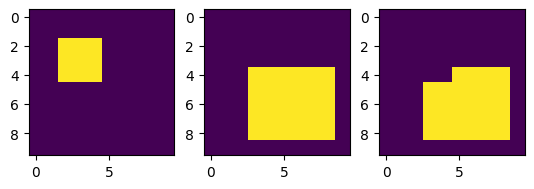

In [66]:
evmask = np.zeros((10,10))
evmask[2:5, 2:5] = 1 #[255,255,255]

mask = np.zeros((10,10))
mask[4:9, 3:9] = True #1#[255,255,255]

mask_reverse = cv2.bitwise_not(evmask)
bitwiseAnd = cv2.bitwise_and(mask, mask_reverse)


fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(evmask)
ax2.imshow(mask)
ax3.imshow(bitwiseAnd)
plt.show()



In [32]:
#Set the values you want here
NEW_FILE = "find_rgb_values_NC_1668004389.png"
TARGET_PIXEL = [[199, 132, 246]]
REPLACE_PIXEL = [255, 255, 255]
# palette = [[0, 0, 0]]
palette = [[0, 0, 0], [246, 229, 226], [127, 122, 107], [107, 170, 237],
           [192, 253, 121], [234, 107, 154], [158, 204, 181],
           [225, 172, 108], [106, 254, 205], [113, 192, 132], [254, 136, 199]]
palette = np.array(palette).transpose()
# palette = np.array(palette).astype(np.uint8)

# rgb_target = np.array(TARGET_PIXEL)  #.astype(np.float32)
replace = np.array(REPLACE_PIXEL)  #.astype(np.float32)
target = np.array(TARGET_PIXEL).transpose()
image = cv2.cvtColor(
    cv2.imread(
        "/home/psa_images/SemiF-AnnotationPipeline/data/semifield-developed-images/NC_2022-11-09/meta_masks/instance_masks/NC_1668004596.png"
    ), cv2.COLOR_BGR2RGB)
# image = cv2.imread("/home/psa_images/SemiF-AnnotationPipeline/data/semifield-developed-images/NC_2022-11-09/meta_masks/instance_masks/NC_1668004596.png")

# image[np.where(np.array([image == rgb_target]).all(axis = 2))] = replace
# cv2.imwrite(NEW_FILE, image)

# temp_mask = (image[:, :, :, None] == palette).all(2).any(-1)

# print(temp_mask.max())
# print(temp_mask.min())
# print(np.unique(temp_mask))

# back_mask = np.where(temp_mask[:, :, None], image, replace[None, None, :])
tmp_mask = (image[:,:,:,None] == target).all(2)#.any(-1)

print(tmp_mask.shape)
print(type(tmp_mask))
print(tmp_mask.dtype)
print(np.unique(tmp_mask))

(6368, 9560, 1)
<class 'numpy.ndarray'>
bool
[False]


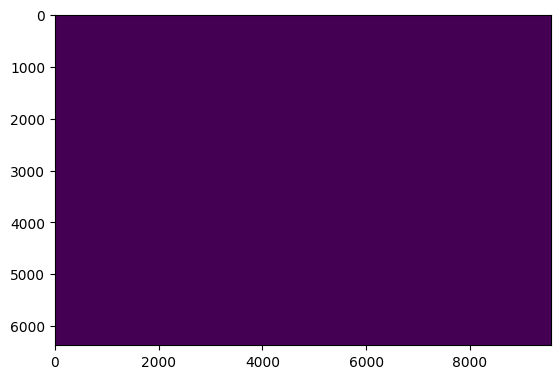

In [26]:
# print(temp_mask.shape)
# print(temp_mask.dtype)
# rgbsave = cv2.cvtColor(back_mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
# cv2.imwrite(NEW_FILE,rgbsave)
# cv2.imwrite(NEW_FILE,back_mask)
plt.imshow(tmp_mask)

In [ ]:
batch_id = "NC_2022-11-09"
df = pd.read_csv(f"../data/semifield-cutouts/{batch_id}/{batch_id}.csv")

df["state_id"] = df.batch_id.str.split("_", expand=False).str[0]
df["date"] = df.batch_id.str.split("_", expand=False).str[1]
df["common_name"] = np.where(df.common_name == "Common lambsquarters", "Lambsquarter", df.common_name)
df["temp_path"] = "../data/semifield-cutouts/" + df["cutout_path"]

In [ ]:
features = [
    "blob_home", "image_id", "cutout_num", "datetime", "cutout_id",
    "is_primary", "extends_border", "r_count", "r_mean", "r_std", "r_min",
    "r_25%", "r_50%", "r_75%", "r_max", "r_variance", "r_skewness",
    "r_kurtosis", "g_count", "g_mean", "g_std", "g_min", "g_25%", "g_50%",
    "g_75%", "g_max", "g_variance", "g_skewness", "g_kurtosis", "b_count",
    "b_mean", "b_std", "b_min", "b_25%", "b_50%", "b_75%", "b_max",
    "b_variance", "b_skewness", "b_kurtosis", "area", "common_name",
    "growth_habit", "duration", "category", "hex", "r", "g", "b", "area_bbox",
    "area_convex", "axis_major_length", "axis_minor_length", "centroid0",
    "centroid1", "eccentricity", "solidity", "perimeter",
    "green_sum", "blur_effect", "num_components", "state_id"
]


In [ ]:
named_featdata = df.loc[:, features]
multfeatdf = named_featdata.groupby(["common_name"]).describe().reset_index()#names=["common_name"])
multfeatdf = multfeatdf[multfeatdf["common_name"]!="colorchecker"]
# print(multfeatdf)
# savedir = "/home/weedsci/matt/SemiF-AnnotationPipeline/assets"
# multfeatdf.to_csv(f"{savedir}/describe_all_cutouts.csv", index=False)
multfeatdf
multfeatdf.columns = multfeatdf.columns.to_flat_index()
multfeatdf.columns = ['_'.join(x) for x in multfeatdf.columns.get_level_values(0)]
for i in multfeatdf.columns:
    print(i)


In [ ]:
# batch = "TX_2023-01-13"
c = df.groupby(["common_name", "state_id", "is_primary"]).cutout_id.count().reset_index().sort_values("cutout_id")
c = c[c["common_name"]!="colorchecker"]
g = sns.catplot(
    data=c,
    x="cutout_id",
    y="common_name",
    hue="is_primary",
    orient="horizontal",
    col="state_id",
    sharey=False,
    kind="bar",
    aspect=.8,
    height=14
)
g.set(xlabel="", ylabel="")
g.set_titles(col_template="{col_name}")
g._legend.set_title("")
# replace labels
new_labels = ['duplicates', 'unique']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

sns.move_legend(g, "center right", bbox_to_anchor=(.9, .55), frameon=False)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Number of Cutouts (sub-images) by Batch')
# g.savefig(f"../assets/Cutouts_for_batch{batch}.png", dpi=300)

In [ ]:
sns.catplot(
    data=multfeatdf, x="area_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

In [ ]:

sns.catplot(
    data=multfeatdf, x="green_sum_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

In [ ]:

sns.catplot(
    data=multfeatdf, x="blur_effect_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

In [ ]:
sns.catplot(
    data=multfeatdf, x="num_components_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

In [ ]:
sns.catplot(
    data=multfeatdf, x="solidity_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

In [ ]:
sns.catplot(
    data=multfeatdf, x="area_bbox_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")